In [70]:
# imports
from commstools.core import SingleCarrierFrame, Preamble
from commstools.logger import set_log_level


set_log_level("WARNING")


In [71]:
symbol_rate = 100e9
sampling_rate = 200e9
sps = int(sampling_rate / symbol_rate)


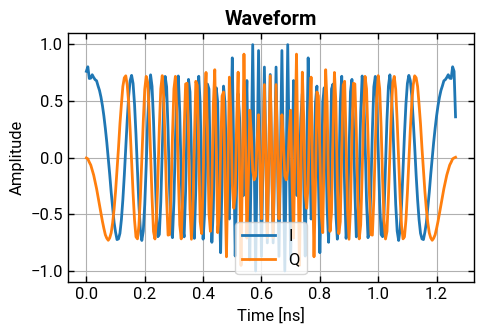

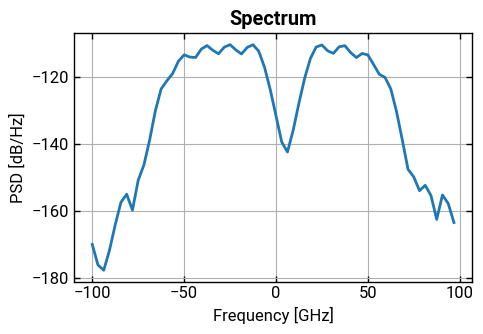

In [72]:
p = Preamble(sequence_type="zc", length=127)
ps = p.to_waveform(sps=sps, symbol_rate=symbol_rate, pulse_shape="rrc")
ps.plot_symbols(show=True)
ps.plot_psd(show=True, nperseg=64)


In [73]:
f = SingleCarrierFrame(
    payload_len=40,
    payload_seed=42,
    payload_mod_scheme="qam",
    payload_mod_order=64,
    preamble=p,
    preamble_gain_db=0.0,
    pilot_pattern="comb",
    pilot_period=10,
    pilot_block_len=1,
    pilot_seed=1337,
    pilot_mod_scheme="qam",
    pilot_mod_order=4,
    pilot_gain_db=0.0,
)


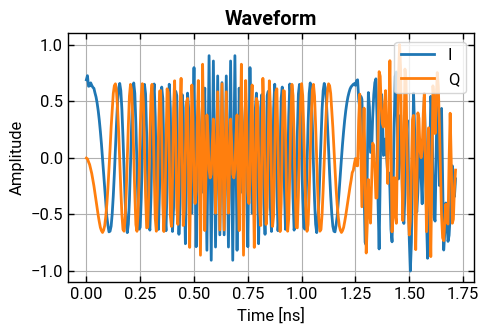

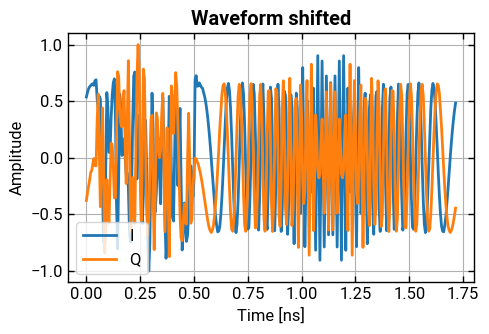

In [74]:
from commstools.backend import get_array_module

fs = f.to_waveform(sps=sps, symbol_rate=symbol_rate, pulse_shape="rrc")
fs.plot_symbols(show=True)

xp = get_array_module(fs.samples)

fs.samples = xp.roll(fs.samples, 101)

fs.plot_symbols(show=True, title="Waveform shifted")


In [75]:
fs.matched_filter()


Signal(samples=array([ 0.59596222-3.95028766e-01j,  0.87110571-4.91917117e-01j,
        0.88745167-3.77818506e-01j,  0.86365002-2.50209463e-01j,
        0.90511185-2.01883166e-01j,  0.92441908-1.45817691e-01j,
        0.90386079-4.71391376e-02j,  0.93065937-4.59171824e-02j,
        0.98719113-1.52842081e-01j,  0.92486887+5.34497241e-04j,
        0.7419977 +5.13968064e-01j,  0.65834796+6.57804769e-01j,
        0.74254623+2.02530265e-02j,  0.71804963-4.31265946e-01j,
        0.31660603+4.18550974e-02j, -0.43030547+4.29408945e-01j,
       -1.09002647-2.23842902e-01j, -1.00422722-1.00148083e+00j,
       -0.09448268-8.58046329e-01j,  0.71907608-4.30250391e-01j,
        0.65002018-5.43135036e-01j,  0.14300364-7.17234370e-01j,
        0.06042268-3.59316438e-01j,  0.43105885+1.45720526e-01j,
        0.78614784+2.22557707e-01j,  1.00359064-1.46004871e-01j,
        1.01250989-5.43262303e-01j,  0.43054093-4.25725487e-01j,
       -0.60145309+3.05579447e-01j, -1.00723725+9.99145964e-01j,
       -0.

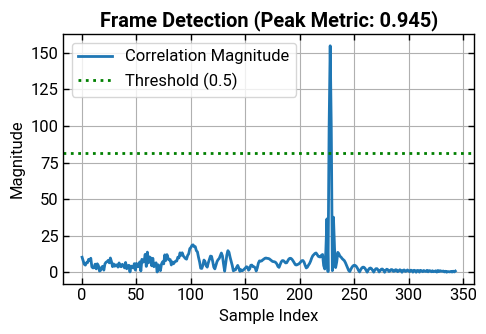

(101, 0.945341856716032)


In [76]:
from commstools.sync import detect_frame

print(detect_frame(fs, ps.samples, return_metric=True, debug_plot=True))
